In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import time
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split,KFold

In [ ]:
frameNum = 60 

# load data
dfs = []
for i in range(1,33):
  for j in range(1,41):
    filename = f"/content/drive/MyDrive/Project/DEAP_project/Files/User{i}_Video{j}.dat"
    cols = np.arange(frameNum)
    df = pd.read_csv(filename, header = None, usecols = cols, delimiter=' ')   
    dfs.append(df.values)
    #print('participant%dvideo%d.txt'%(i,j))

dfs = np.array(dfs)
print('dataLoaded:')
print(dfs.shape)

dataLoaded:
(1280, 1024, 60)


In [ ]:
# normalize
x_min = dfs.min(axis = (1,2),keepdims=True)
x_max = dfs.max(axis = (1,2),keepdims=True)
dfs_normal = (dfs-x_min)/(x_max-x_min)
print(dfs_normal.shape)

(1280, 1024, 60)


In [ ]:
depth = 3
# divide frames ,or 60s is too long for a single 3dinput
reshape_dfs = np.split(dfs_normal, frameNum/depth, axis=2)
reshape_dfs = np.array(reshape_dfs)
reshape_dfs = np.reshape(reshape_dfs,[-1,1024,depth])
print(reshape_dfs.shape)

(25600, 1024, 3)


In [ ]:
# load label
label_dfv = pd.read_csv('/content/drive/MyDrive/Project/DEAP_project/labels_class_0.csv',
    names = ['valence'], header=None, delimiter=',' )

label_dfa = pd.read_csv('/content/drive/MyDrive/Project/DEAP_project/labels_class_1.csv',
    names = ['arousal'], header=None, delimiter=',' )

label_dfd = pd.read_csv('/content/drive/MyDrive/Project/DEAP_project/labels_class_2.csv',
    names = ['dominance'], header=None, delimiter=',' )

label_dfl = pd.read_csv('/content/drive/MyDrive/Project/DEAP_project/labels_class_3.csv',
    names = ['liking'], header=None, delimiter=',' )

#label_dfv
print(label_dfv.shape, label_dfa.shape, label_dfd.shape, label_dfl.shape)

(1280, 1) (1280, 1) (1280, 1) (1280, 1)


In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,5.744679e-05,2.553555e-04,6.081591e-04,0.001022,1.358385e-03,1.512967e-03,1.435924e-03,0.001143,6.851798e-04,2.540377e-04,2.515145e-05,4.256839e-05,3.387648e-04,7.932724e-04,1.293145e-03,1.830145e-03,2.113265e-03,2.126711e-03,2.090080e-03,1.752176e-03,1.128011e-03,5.879317e-04,1.589749e-04,7.529879e-06,3.311412e-04,1.066608e-03,2.167551e-03,3.174010e-03,3.606429e-03,3.461898e-03,2.685057e-03,1.473901e-03,4.517255e-04,1.011573e-05,2.139682e-04,9.079186e-04,1.615117e-03,1.944151e-03,1.863530e-03,1.350929e-03,6.383102e-04,1.674350e-04,2.304194e-06,8.786442e-05,2.667910e-04,3.179301e-04,2.725295e-04,1.314097e-04,5.152928e-06,3.627495e-05,1.440838e-04,2.968252e-04,3.327871e-04,1.907146e-04,5.777137e-05,3.531563e-07,1.131937e-04,3.096933e-04,4.225250e-04,4.598667e-04
1,1.896244e-04,5.140935e-04,9.558036e-04,0.001427,1.749479e-03,1.818524e-03,1.688201e-03,0.001282,7.126611e-04,2.659181e-04,2.139997e-05,8.383755e-05,4.852638e-04,1.115436e-03,1.952279e-03,2.684905e-03,3.061170e-03,3.154436e-03,2.897733e-03,2.245846e-03,1.372144e-03,5.760688e-04,8.808176e-05,4.936108e-05,5.731338e-04,1.486753e-03,2.571416e-03,3.546705e-03,3.882380e-03,3.551018e-03,2.769920e-03,1.632424e-03,6.002790e-04,6.465823e-05,6.126383e-05,4.713848e-04,1.032480e-03,1.493432e-03,1.614523e-03,1.315787e-03,8.295955e-04,4.043184e-04,1.293135e-04,1.045399e-05,1.139413e-05,5.461020e-05,6.275913e-05,2.383397e-05,6.124094e-08,1.239766e-05,3.900513e-05,6.972865e-05,8.060219e-05,5.384183e-05,1.027467e-05,8.422783e-06,8.241706e-05,1.739351e-04,2.199536e-04,2.423155e-04
2,4.424911e-04,8.062397e-04,1.327554e-03,0.001792,1.963859e-03,1.990143e-03,1.746486e-03,0.001241,7.093119e-04,2.072976e-04,3.325519e-07,1.465292e-04,6.960528e-04,1.585198e-03,2.415996e-03,3.212925e-03,3.755887e-03,3.740298e-03,3.344894e-03,2.461539e-03,1.389175e-03,5.863280e-04,6.622161e-05,1.023253e-04,6.609005e-04,1.559976e-03,2.668947e-03,3.498377e-03,3.827351e-03,3.554760e-03,2.770956e-03,1.844661e-03,8.801304e-04,1.885402e-04,1.133796e-07,1.577027e-04,5.751423e-04,9.925312e-04,1.161391e-03,1.148302e-03,1.002498e-03,7.232997e-04,4.064526e-04,1.849378e-04,7.874066e-05,2.888169e-05,5.063919e-06,6.902536e-07,4.603349e-06,1.272046e-05,9.325482e-06,8.649716e-06,1.195799e-05,2.304283e-06,5.011289e-06,3.122549e-05,7.142586e-05,1.206939e-04,1.962808e-04,2.646049e-04
3,6.990651e-04,1.194994e-03,1.604066e-03,0.001909,2.080131e-03,1.977483e-03,1.597441e-03,0.001060,5.215706e-04,1.201247e-04,7.186504e-06,2.977523e-04,9.338055e-04,1.811587e-03,2.745294e-03,3.480222e-03,3.906902e-03,3.866600e-03,3.241269e-03,2.361591e-03,1.418502e-03,5.314108e-04,4.736942e-05,7.828116e-05,6.010440e-04,1.479109e-03,2.389917e-03,3.134692e-03,3.531296e-03,3.400006e-03,2.806218e-03,1.970096e-03,1.123127e-03,4.329820e-04,5.339629e-05,2.446530e-05,2.284209e-04,5.419524e-04,8.283843e-04,9.929849e-04,1.021245e-03,9.125178e-04,7.295112e-04,5.364457e-04,3.490738e-04,2.107384e-04,1.341033e-04,7.616255e-05,3.121517e-05,1.554591e-05,1.236240e-05,3.730674e-06,4.530567e-07,8.414927e-06,2.729891e-05,6.257979e-05,1.118084e-04,1.828313e-04,2.560754e-04,2.950363e-04
4,9.715428e-04,1.380071e-03,1.751842e-03,0.001996,1.949584e-03,1.673408e-03,1.313303e-03,0.000843,3.323800e-04,3.403212e-05,4.631238e-05,4.187476e-04,1.091465e-03,1.876350e-03,2.756058e-03,3.489466e-03,3.690494e-03,3.489399e-03,3.034858e-03,2.183348e-03,1.182209e-03,4.670883e-04,7.002150e-05,4.998796e-05,4.879274e-04,1.177303e-03,1.999465e-03,2.707224e-03,3.007775e-03,3.028803e-03,2.736243e-03,2.026746e-03,1.266788e-03,6.651965e-04,2.015677e-04,4.657132e-06,5.333179e-05,2.265728e-04,5.139367e-04,8.007939e-04,9.430664e-04,9.953684e-04,9.600403e-04,8.076155e-04,6.672591e-04,5.456404e-04,3.569217e-04,2.024724e-04,1.259403e-04,5.971873e-05,1.602134e-05,2.763704e-06,2.016952e-06,3.032129e-05,6.418142e-05,1.023652e-04,1.876355e-0

In [ ]:
labelv = np.tile(label_dfv['valence'].astype(int).values,20)
labela = np.tile(label_dfa['arousal'].astype(int).values,20)
labeld = np.tile(label_dfd['dominance'].astype(int).values,20)
labell = np.tile(label_dfl['liking'].astype(int).values,20)
print(labelv.shape, labela.shape, labeld.shape, labell.shape)

(25600,) (25600,) (25600,) (25600,)


In [ ]:
class cnn_classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv11 = nn.Conv3d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.conv12 = nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.pool1 = nn.MaxPool3d(kernel_size=2, padding=(0,0,1))
    
    self.conv21 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.conv22 = nn.Conv3d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.pool2 = nn.MaxPool3d(kernel_size=2, padding=(0,0,1))
    
    self.conv31 = nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.conv32 = nn.Conv3d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.pool3 = nn.MaxPool3d(kernel_size=2, padding=0)
    

    self.fc_layer = nn.Linear(128*4*4*1, 2)
    
    self.dropout_layer = nn.Dropout(p=0.5)

  def forward(self, xb):
    h1 = self.conv11(xb)
    h1 = self.conv12(h1)
    h1 = self.dropout_layer(h1)
    h1 = self.pool1(h1)
    h1 = F.relu(h1)

    h2 = self.conv21(h1)
    h2 = self.conv22(h2)
    #h2 = self.dropout_layer(h2)
    h2 = self.pool2(h2)
    h2 = F.relu(h2) 

    h3 = self.conv31(h2)
    h3 = self.conv32(h3)
    #h3 = self.dropout_layer(h3)
    h3 = self.pool3(h3)
    h3 = F.relu(h3) 
    
    
    flatten = h3.view(-1, 128*4*4*1)
    out = self.fc_layer(flatten)
    #out = self.dropout_layer(out)
    return out

In [ ]:
def train_model(model, x_train, y_train, x_test, y_test, epochs=50 , batch_size=32, lr=0.0001, weight_decay=0):
  # data
  train_dataset = TensorDataset(x_train, y_train)
  train_data_loader = DataLoader(train_dataset, batch_size=batch_size)

  # loss function
  loss_func = F.cross_entropy

  # optimizer
  #optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

  # figure
  train_a = list([])
  test_a = list([])

  # training loop
  for epoch in range(epochs):
    model.train()
    tic = time.time()
    acc_train = []
    for xb, yb in train_data_loader:    
      xb, yb = xb.to(device), yb.to(device)
      pred = model(xb)
      loss = loss_func(pred, yb)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      acc_train.append(pred.detach().argmax(1).eq(yb).float().mean().cpu().numpy())
    acc_train = np.mean(acc_train)
    toc = time.time()
    
    with torch.no_grad():
      model.eval()
      y_pred = model(x_test.to(device))
      acc = y_pred.argmax(1).eq(y_test.to(device)).float().mean().cpu().numpy()

    train_a.append(acc_train)
    test_a.append(acc)
    print('Loss at epoch %d : %f, train_acc: %f, test_acc: %f, running time: %d'% (epoch, loss.item(), acc_train, acc, toc-tic))
  
  train_amax = max(train_a)
  test_amax = max(test_a)

  # draw an accuray figure
  #plt.plot(train_a,'y.-.')
  #plt.plot(test_a,'.-.')
  #plt.xlabel('epoch')
  #plt.ylabel('accuracy')
  return train_a,test_a

In [ ]:
# divive train & test
x_train, x_test, y_train, y_test = train_test_split(reshape_dfs, labelv, test_size=0.2, random_state=1)

x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).long()

print(x_train.shape,  y_train.shape,x_test.shape, y_test.shape)

torch.Size([20480, 1024, 3]) torch.Size([20480]) torch.Size([5120, 1024, 3]) torch.Size([5120])


cuda
Loss at epoch 0 : 0.651872, train_acc: 0.631152, test_acc: 0.632617, running time: 24
Loss at epoch 1 : 0.646303, train_acc: 0.631689, test_acc: 0.633203, running time: 24
Loss at epoch 2 : 0.649595, train_acc: 0.632178, test_acc: 0.633984, running time: 24
Loss at epoch 3 : 0.655886, train_acc: 0.639551, test_acc: 0.638672, running time: 25
Loss at epoch 4 : 0.659059, train_acc: 0.652588, test_acc: 0.647852, running time: 25
Loss at epoch 5 : 0.655039, train_acc: 0.670459, test_acc: 0.667188, running time: 25
Loss at epoch 6 : 0.651631, train_acc: 0.688965, test_acc: 0.678711, running time: 25
Loss at epoch 7 : 0.647162, train_acc: 0.712793, test_acc: 0.690820, running time: 25
Loss at epoch 8 : 0.632144, train_acc: 0.732471, test_acc: 0.706641, running time: 25
Loss at epoch 9 : 0.590177, train_acc: 0.752588, test_acc: 0.727148, running time: 25
Loss at epoch 10 : 0.578015, train_acc: 0.773096, test_acc: 0.733203, running time: 25
Loss at epoch 11 : 0.567159, train_acc: 0.794727

Text(0, 0.5, 'accuracy')

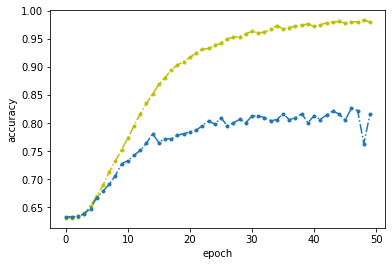

In [ ]:
model = cnn_classifier()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = model.to(device)
train_a,test_a = train_model(model, x_train.view(-1, 1, 32, 32, 3), y_train, x_test.view(-1, 1, 32, 32, 3), y_test)
# draw an accuray figure
plt.plot(train_a,'y.-.')
plt.plot(test_a,'.-.')
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Project/DEAP_project/CNN_model_valence.pth')

In [ ]:
# divive train & test
x_train, x_test, y_train, y_test = train_test_split(reshape_dfs, labela, test_size=0.2, random_state=1)

x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).long()

print(x_train.shape,  y_train.shape,x_test.shape, y_test.shape)

torch.Size([20480, 1024, 3]) torch.Size([20480]) torch.Size([5120, 1024, 3]) torch.Size([5120])


cuda
Loss at epoch 0 : 0.603420, train_acc: 0.640234, test_acc: 0.626563, running time: 23
Loss at epoch 1 : 0.602379, train_acc: 0.640234, test_acc: 0.626563, running time: 23
Loss at epoch 2 : 0.574604, train_acc: 0.641162, test_acc: 0.631250, running time: 24
Loss at epoch 3 : 0.571186, train_acc: 0.648291, test_acc: 0.636914, running time: 24
Loss at epoch 4 : 0.566554, train_acc: 0.662354, test_acc: 0.649414, running time: 24
Loss at epoch 5 : 0.562005, train_acc: 0.679590, test_acc: 0.664062, running time: 25
Loss at epoch 6 : 0.552040, train_acc: 0.697461, test_acc: 0.677734, running time: 25
Loss at epoch 7 : 0.533015, train_acc: 0.717920, test_acc: 0.697852, running time: 25
Loss at epoch 8 : 0.524916, train_acc: 0.742041, test_acc: 0.712305, running time: 25
Loss at epoch 9 : 0.499681, train_acc: 0.760449, test_acc: 0.725195, running time: 25
Loss at epoch 10 : 0.464226, train_acc: 0.783008, test_acc: 0.734375, running time: 25
Loss at epoch 11 : 0.442861, train_acc: 0.803906

Text(0, 0.5, 'accuracy')

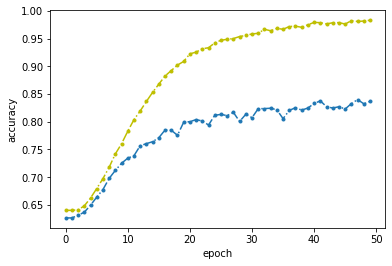

In [ ]:
model = cnn_classifier()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = model.to(device)
train_a,test_a = train_model(model, x_train.view(-1, 1, 32, 32, 3), y_train, x_test.view(-1, 1, 32, 32, 3), y_test)
# draw an accuray figure
plt.plot(train_a,'y.-.')
plt.plot(test_a,'.-.')
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Project/DEAP_project/CNN_model_arousal.pth')